In [1]:
import os
import sys
import time
import argparse
import numpy as np
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from models.efficientdet import EfficientDet
from models.losses import FocalLoss
from datasets import Spine_dataset, get_augumentation, detection_collate
from utils import EFFICIENTDET
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
resume = 'weights/checkpoint_efficientdet-d3_33.pth'
network = 'efficientdet-d3'
num_epochs = 100
batch_size = 1
num_worker = 4
num_classes = 1
device = [0]
grad_accumulation_steps = 1
learning_rate = 1e-4
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
save_folder = 'weights/'
image_root = 'boostnet_labeldata/data/'
csv_root = 'boostnet_labeldata/labels/'

In [3]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

In [4]:
def prepare_device(device):
    n_gpu_use = len(device)
    n_gpu = torch.cuda.device_count()
    if n_gpu_use > 0 and n_gpu == 0:
        print("Warning: There\'s no GPU available on this machine, training will be performed on CPU.")
        n_gpu_use = 0
    if n_gpu_use > n_gpu:
        print("Warning: The number of GPU\'s configured to use is {}, but only {} are available on this machine.".format(
            n_gpu_use, n_gpu))
        n_gpu_use = n_gpu
    list_ids = device
    device = torch.device('cuda:{}'.format(
        device[0]) if n_gpu_use > 0 else 'cpu')

    return device, list_ids

In [5]:
def get_state_dict(model):
    if type(model) == torch.nn.DataParallel:
        state_dict = model.module.state_dict()
    else:
        state_dict = model.state_dict()
    return state_dict

In [6]:
checkpoint = []
if(resume is not None):
    resume_path = str(resume)
    print("Loading checkpoint: {} ...".format(resume_path))
    checkpoint = torch.load(
        resume, map_location=lambda storage, loc: storage)
    num_classes = checkpoint['num_class']
    network = checkpoint['network']

Loading checkpoint: weights/checkpoint_efficientdet-d3_33.pth ...


In [7]:
corner_df_train = pd.read_csv(csv_root+'training/landmarks.csv',header = None)
filename_df_train = pd.read_csv(csv_root+'training/filenames.csv',header = None)
boxes_df_train = pd.read_csv(csv_root+'training/train.csv')
boxes_df_train.label = 0 # All boxes same class??

In [8]:
corner_df_test = pd.read_csv(csv_root+'test/landmarks.csv',header = None)
filename_df_test = pd.read_csv(csv_root+'test/filenames.csv',header = None)
boxes_df_test = pd.read_csv('test.csv')
boxes_df_test.label = 0

In [9]:
train_dataset = Spine_dataset.SPINEDetection(image_root,boxes_df_train,corner_df_train,filename_df_train,transform=get_augumentation('train'))

In [10]:
val_dataset = Spine_dataset.SPINEDetection(image_root,boxes_df_test,corner_df_test,filename_df_test,transform=get_augumentation('val'),image_set='test')

In [11]:
test_dataset = Spine_dataset.SPINEDetection_test(transform=get_augumentation('test'))

In [12]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=True,
                              collate_fn=detection_collate,
                              pin_memory=True)

In [13]:
val_dataloader = DataLoader(val_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True)

In [14]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=False,
                              collate_fn=None,
                              pin_memory=True)

In [15]:
for idx, (images, annotations, corners) in enumerate(train_dataloader):
    print(idx ,images.shape, annotations.shape, corners.shape)
    break

0 torch.Size([1, 3, 1408, 768]) torch.Size([1, 17, 5]) torch.Size([1, 17, 8])


In [16]:
model = EfficientDet(num_classes=num_classes,
                     network=network,
                     W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                     D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                     D_class=EFFICIENTDET[network]['D_class'],
                     )

Loaded pretrained weights for efficientnet-b3


In [17]:
if(resume is not None):
    model.load_state_dict(checkpoint['state_dict'])
device, device_ids = prepare_device(device)
model = model.to(device)
if(len(device_ids) > 1):
    model = torch.nn.DataParallel(model, device_ids=device_ids)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, verbose=True)
criterion = FocalLoss()

In [ ]:
model.train()
for epoch in range(num_epochs):
    print("{} epoch: \t start training....".format(epoch))
    
    start = time.time()
    result = {}
    total_loss = []
    corner_losses = []
    bbox_losses = []
    cls_losses = []
    optimizer.zero_grad()
    total_batches = len(train_dataloader)
    tk0 = tqdm(train_dataloader, total=total_batches)
    for idx, (images, annotations_bboxes, annotations_corners) in enumerate(tk0):
        images = images.to(device)
        annotations_bboxes = annotations_bboxes.to(device)
        annotations_corners = annotations_corners.to(device)
        classification, regression, corners, anchors = model(images)
        classification_loss, regression_loss, corner_loss= criterion(
            classification, regression, corners, anchors, annotations_bboxes, annotations_corners)
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        corner_loss = corner_loss.mean()
        loss = classification_loss + regression_loss + corner_loss
        if bool(loss == 0):
            print('loss equal zero(0)')
            continue
        loss.backward()
        if (idx+1) % grad_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()
        total_loss.append(loss.item())
        corner_losses.append(corner_loss.item())
        bbox_losses.append(regression_loss.item())
        cls_losses.append(classification_loss.item())
        tk0.set_postfix(loss=(np.mean(total_loss)))
    result = {
        'time': time.time() - start,
        'loss': np.mean(total_loss),
        'corner_loss': np.mean(corner_losses),
        'bbox_loss': np.mean(bbox_losses),
        'cls_loss': np.mean(cls_losses)
    }
    for key, value in result.items():
        print('    {:15s}: {}'.format(str(key), value)) 
        
    start = time.time()
    result = {}
    total_loss = []
    corner_losses = []
    bbox_losses = []
    cls_losses = []
    optimizer.zero_grad()
    total_batches = len(val_dataloader)
    tk0 = tqdm(val_dataloader, total=total_batches)
    for idx, (images, annotations_bboxes, annotations_corners) in enumerate(tk0):
        images = images.to(device)
        annotations_bboxes = annotations_bboxes.to(device)
        annotations_corners = annotations_corners.to(device)
        classification, regression, corners, anchors = model(images)
        classification_loss, regression_loss, corner_loss= criterion(
            classification, regression, corners, anchors, annotations_bboxes, annotations_corners)
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        corner_loss = corner_loss.mean()
        loss = classification_loss + regression_loss + corner_loss
        if bool(loss == 0):
            print('loss equal zero(0)')
            continue
        total_loss.append(loss.item())
        corner_losses.append(corner_loss.item())
        bbox_losses.append(regression_loss.item())
        cls_losses.append(classification_loss.item())
        tk0.set_postfix(loss=(np.mean(total_loss)))
    result = {
        'time': time.time() - start,
        'loss': np.mean(total_loss),
        'corner_loss': np.mean(corner_losses),
        'bbox_loss': np.mean(bbox_losses),
        'cls_loss': np.mean(cls_losses)
    }
    for key, value in result.items():
        print('    {:15s}: {}'.format(str(key), value))
    scheduler.step(np.mean(total_loss))

    arch = type(model).__name__
    state = {
        'arch': arch,
        'num_class': num_classes,
        'network': network,
        'state_dict': get_state_dict(model)
    }
    torch.save(
        state, './weights/checkpoint_{}_{}.pth'.format(network, epoch))
state = {
    'arch': arch,
    'num_class': num_classes,
    'network': network,
    'state_dict': get_state_dict(model)
}
torch.save(state, './weights/Final_{}.pth'.format(network))

In [ ]:
model.is_training = False

In [ ]:
def vis(dataloader,split = 'test'):
    if split=='test':
        for idx, (images) in enumerate(dataloader):
            images = images.to(device)
            image = images[0]
            classification_score, category, boxes, corners = model(images)
            break
    else:
        for idx, (images, annotations, corners) in enumerate(dataloader):
            image = images[0]
            images = images.to(device)
            classification_score, category, boxes, corners = model(images)
            break
    corners = corners.detach().cpu().numpy()
    boxes = boxes.detach().cpu().numpy()
    image = image.detach().cpu().numpy()
    image = image.transpose(1,2,0)
    boxes = boxes.astype(np.int16)
    for box in boxes:
        start = (box[0],box[1])
        end = (box[2],box[3])
        image = cv2.rectangle(image, start, end, (255,0,0), 10)
    plt.scatter(corners[:,:4],corners[:,4:])
    plt.imshow(image.get())

In [ ]:
vis(train_dataloader,'a')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


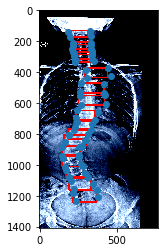

In [22]:
vis(test_dataloader)

In [23]:
def get_predictions(dataloader = val_dataloader):
    corners = []
    clipped_corners = []
    
    # Predictions from model
    for idx, (image, annotation, corner) in enumerate(val_dataloader):
        image = image.to(device)
        classification_score, category, pred_boxes, pred_corner = model(image)
        classification_score = classification_score.detach().cpu().numpy()
        pred_corner = pred_corner.detach().cpu().numpy()
        if classification_score.shape[0]>17:
            ind = np.argpartition(classification_score, -17)[-17:]
            corners.append(pred_corner[ind])
        else:
            corners.append(pred_corner)
    
    #Making all predictions 17
    for corner in corners:
        if corner.shape[0]==17:
            clipped_corners.append(corner)
        else:
            num_repeat = 17-corner.shape[0]
            repeat = corner[-1].reshape(1,8)
            for i in range(num_repeat):
                corner = np.append(corner,repeat,axis=0)
            clipped_corners.append(corner)
    
    clipped_corners = np.array(clipped_corners)
    
    #Reshaping and saving csv
    val_landmarks = np.zeros((len(clipped_corners),136))
    for i in range(len(clipped_corners)):
        val_landmarks[i,:68] = clipped_corners[i,:,:4].reshape(1,68)/768
        val_landmarks[i,68:] = clipped_corners[i,:,4:].reshape(1,68)/1408
    
    val_preds = pd.DataFrame(val_landmarks)
    val_preds.to_csv('val_preds.csv',header = None,index = False)
    return val_preds

In [24]:
get_predictions()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.477574,0.655324,0.500802,0.677007,0.298726,0.433619,0.348837,0.490066,0.424913,0.520632,...,0.061422,0.064349,0.363759,0.363813,0.405271,0.401664,0.423433,0.409310,0.463700,0.444726
1,0.347359,0.470852,0.352027,0.497962,0.365572,0.513093,0.405228,0.545677,0.418804,0.565941,...,0.159763,0.170307,0.059798,0.058468,0.081517,0.084341,0.895340,0.900157,0.927088,0.931330
2,0.336536,0.481913,0.342116,0.483127,0.491335,0.646437,0.482738,0.640239,0.324437,0.470080,...,0.728404,0.724067,0.215706,0.199835,0.247722,0.233996,0.215706,0.199835,0.247722,0.233996
3,0.433554,0.590787,0.432918,0.587281,0.269209,0.428275,0.305761,0.462588,0.364174,0.465663,...,0.111064,0.118884,0.443658,0.440020,0.480095,0.472666,0.499551,0.485286,0.540705,0.523913
4,0.333708,0.476616,0.372310,0.521410,0.253323,0.383432,0.273508,0.411777,0.286005,0.422639,...,0.093681,0.092933,0.803919,0.796968,0.842333,0.841337,0.869850,0.876775,0.902749,0.911457
5,0.419598,0.524374,0.398779,0.492959,0.501197,0.677914,0.525552,0.703841,0.461643,0.589314,...,0.291963,0.313641,0.584926,0.556288,0.622173,0.590368,0.482988,0.468961,0.517394,0.500892
6,0.262731,0.393801,0.291221,0.430349,0.383082,0.521143,0.426163,0.571917,0.240281,0.365555,...,0.791282,0.779341,0.815377,0.806162,0.853788,0.848123,0.876729,0.871803,0.913403,0.909138
7,0.242607,0.374060,0.280036,0.405943,0.397596,0.530062,0.394309,0.524541,0.515800,0.720794,...,0.205512,0.224870,0.559119,0.531423,0.599249,0.571240,0.218814,0.233804,0.245199,0.262794
8,0.457755,0.607010,0.461632,0.599926,0.331688,0.471891,0.343624,0.490613,0.417492,0.521017,...,0.617525,0.604867,0.514986,0.500855,0.556702,0.539322,0.459000,0.444215,0.499142,0.480039
9,0.359303,0.499644,0.348103,0.491014,0.337036,0.515034,0.352081,0.517863,0.501771,0.710314,...,0.816314,0.795842,0.553154,0.529652,0.592350,0.563172,0.712314,0.678866,0.752115,0.723699


In [27]:
import numpy as np
import pandas as pd

## find the SMAPE error
def smape(y_true, y_pred):
    numerator = np.sum(np.abs(y_true-y_pred), axis=1)
    denominator = np.sum(np.abs(y_true+y_pred), axis=1)
    smape_val = np.mean(numerator/ denominator) * 100
    return smape_val



true_csv_path = "boostnet_labeldata/labels/test/angles.csv"
pred_csv_path = "boostnet_labeldata/labels/test/test_angles_polyfit.csv"
true_angles = pd.read_csv(true_csv_path, header=None).values
pred_angles = pd.read_csv(pred_csv_path, header=None).values
print (smape(true_angles, pred_angles))

21.645940169945398
